In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../..")
sys.path.append("../")
sys.path.append("./")

In [5]:
from src.data_pipeline.DataLoader import DataLoader
from src.utility.sys_utils import get_spark

# import result checking tools
from src.utility.Summary import Summary

In [6]:
spark = get_spark(cores=4) # change cores up to 6 if needed
dataloader = DataLoader(dataset_name="user_10_item_1_exp", config_name="default_config.json")

### Visualization of Evaluation Metric to Recommendation Size

In [7]:
summary = Summary(dataloader.get_config().db_path)
summary

In [8]:
hyper = summary.get_optimal_params("user_10_item_1_exp", "surprise_SVD", "ndcg@1")

result = summary.get_result_for_params("user_10_item_1_exp", "surprise_SVD", hyper, "ndcg@1")
result

Best ndcg@1 of surprise_SVD is found as 0.02730583581647411
For model surprise_SVD, it has a ndcg@1 of 0.02730583581647411


,model,hyper,metric,value,ts
0,surprise_SVD,"[('lr_all', 0.002), ('n_factors', 10), ('reg_a...",ndcg@1,0.027306,2019-12-18 01:58:00.216802


### Read ndcg top k info from parsed csv

In [9]:
parsed = pd.read_csv("../../parse_results/topk_results.csv", sep = ',')
parsed.head()

,Unnamed: 0,model,hyper,metric,value,ts,k
0,0,CollectiveMF_Item,"[('k', 16), ('reg_param', 0.01), ('w_main', 0.5)]",ndcg@1,0.055422,2019-12-18 01:32:20.734647,1
1,1,CollectiveMF_Item,"[('k', 16), ('reg_param', 0.01), ('w_main', 0.5)]",ndcg@2,0.078422,2019-12-18 01:32:38.024594,2
2,2,CollectiveMF_Item,"[('k', 16), ('reg_param', 0.01), ('w_main', 0.5)]",ndcg@3,0.092794,2019-12-18 01:32:55.187776,3
3,3,CollectiveMF_Item,"[('k', 16), ('reg_param', 0.01), ('w_main', 0.5)]",ndcg@4,0.103548,2019-12-18 01:33:12.001429,4
4,4,CollectiveMF_Item,"[('k', 16), ('reg_param', 0.01), ('w_main', 0.5)]",ndcg@5,0.112015,2019-12-18 01:33:29.350053,5


In [10]:
parsed['model'].unique()

array(['CollectiveMF_Item', 'CollectiveMF_User', 'CollectiveMF_Both',
       'CollectiveMF_No', 'surprise_SVD', 'surprise_Baseline',
       'PureRandom', 'FMItem', 'FMNone', 'BPR'], dtype=object)

In [67]:
parsed[parsed['model']=='BPR'].head()

,Unnamed: 0,model,hyper,metric,value,ts,k
90,90,BPR,"[('factors', 16), ('iteration', 100), ('learni...",ndcg@1,0.065233,2019-12-18 07:51:42.829660,1
91,91,BPR,"[('factors', 16), ('iteration', 100), ('learni...",ndcg@2,0.093214,2019-12-18 07:52:10.560294,2
92,92,BPR,"[('factors', 16), ('iteration', 100), ('learni...",ndcg@3,0.111106,2019-12-18 07:52:37.923441,3
93,93,BPR,"[('factors', 16), ('iteration', 100), ('learni...",ndcg@4,0.124194,2019-12-18 07:53:04.796126,4
94,94,BPR,"[('factors', 16), ('iteration', 100), ('learni...",ndcg@5,0.134559,2019-12-18 07:53:32.115372,5


In [69]:
modelname = parsed['model'].unique()
modelname

array(['CollectiveMF_Item', 'CollectiveMF_User', 'CollectiveMF_Both',
       'CollectiveMF_No', 'surprise_SVD', 'surprise_Baseline',
       'PureRandom', 'FMItem', 'FMNone', 'BPR'], dtype=object)

In [72]:
## plot ndcg@k for all models
def plot_topk_ndcg(dataframe):
    """
    Input: a tidy dataframe with topk for all models
    Output: a ndcg@k plot
    """
    ## add more if needed
    color = ['black','m','goldenrod', 'wheat', 'c',
            'brown', 'slateblue', 'skyblue', 'yellowgreen', 
             'tomato', 'darkorange', 'lavender'] 
    marker = ['P', '^' ,'o','H', 'v', 'D', 'X', 'p', 'x','*']
    
    ## get model names (number of line)
    dfs = dict(tuple(dataframe.groupby('model')))
    modelname = dataframe['model'].unique()
    
    ## size of template
    size = len(modelname)
    colorsize = len(color)
    markersize = len(marker)
    tempsize = min(colorsize, markersize)
    
    ## plotting
    fig, ax = plt.subplots(1,1, figsize = (7,6))
    
    t = 0 ## default template index
    for i in range(size):
        t = i
        if t > tempsize: ## reset 
            t = 0    
        ax.plot(dfs[modelname[i]]['k'], dfs[modelname[i]]['value'], 
            marker=marker[t], color=color[t], linewidth=2, label = modelname[i])
        t =+ 1
    ax.legend()
    ax.set_xlabel("k", fontsize = 18)
    ax.set_ylabel('value', fontsize = 18)
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)
    ax.set_title("ndcg@k " , fontsize = 22)
    
    plt.savefig('ndcg@k', format='eps')
    
    return ax


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


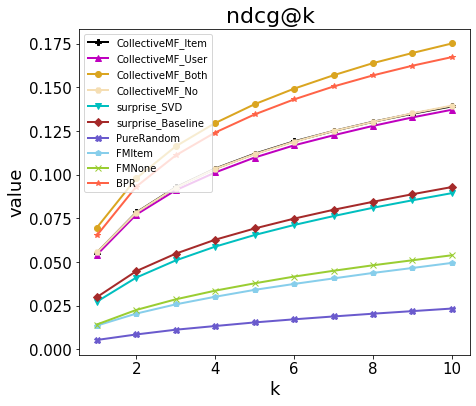

In [73]:
plot_topk_ndcg(parsed)

### Spatial Distribution

In [49]:
spatial = pd.read_csv("~/data/yelp_dataset/tidy_data/sampled_edav_subset/full.csv", sep = ',')
spatial.head()

,Unnamed: 0,user_id,business_id,top_category,state,city,latitude,longitude
0,0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
1,1,RBXSJA372ilErzNwz0jXvQ,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
2,2,x3brMMbJrAW9PwW5A6YL5w,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
3,3,Skzdl0sWhW88525a1vr59g,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
4,4,3Y25VDfnQVcuc33T-U3Z6A,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798


In [50]:
## get top category per state
spatial_sub = spatial[['state', 'business_id', 'top_category','user_id']]
spatial_sub = spatial_sub.set_index(['state', 'top_category'])
info = spatial_sub.groupby(by = ['state', 'top_category']).nunique()
info = info.reset_index()
info.head()

,state,top_category,business_id,user_id
0,AB,Active Life,238,1201
1,AB,Arts & Entertainment,220,1585
2,AB,Automotive,468,1954
3,AB,Beauty & Spas,828,3620
4,AB,Education,78,395


In [51]:
key = pd.DataFrame(info.groupby(['state'], sort=False)['business_id'].max())
key.reset_index()
info_gettop = info.merge(key, how='inner', on=['state', 'business_id'])
info_gettop = info_gettop[['state', 'top_category']]
info_gettop.head()

,state,top_category
0,AB,Restaurants
1,AK,Education
2,AK,Nightlife
3,AL,Food
4,AR,Food


In [52]:
spatial_sub2 = spatial[['state', 'business_id','user_id']]
concat = list(spatial_sub2['business_id']+spatial_sub2['user_id'])
spatial_sub2['biz_user_pair'] = concat
# spatial_sub2
spatial_sub2 = spatial_sub2.set_index(['state'])
info2 = spatial_sub2.groupby(by = ['state']).nunique()
info2 = info2.reset_index()
info2.head()

info_getall = info2.merge(info_gettop, how = 'left', on = 'state').rename(columns = {'top_category':'topCat'})
info_getall.head()

/opt/anaconda3/envs/Spark/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,state,business_id,user_id,biz_user_pair,topCat
0,AB,7998,24997,96763,Restaurants
1,AK,2,7,7,Education
2,AK,2,7,7,Nightlife
3,AL,3,12,12,Food
4,AR,1,7,7,Food


In [53]:
import chart_studio as py
import plotly.graph_objects as go

df = info_getall

## get column names
for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['state'] + '<br>' + \
    'User Count: ' + df['user_id'] + '<br>' + \
    'Business Count: ' + df['business_id'] + '<br>' + \
    'Mostly Reviewed Category: ' + df['topCat'] 

fig = go.Figure(data=go.Choropleth(
    locations=df['state'], # Spatial coordinates
    z = df['biz_user_pair'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title = "Review Count",
))

fig.update_layout(
    title_text = 'Spatial Distribution of Reviews',
    geo_scope='usa', 
#     geo_scope='north america',
)

fig.show()

### Category Histogram

In [54]:
spatial.head()

,Unnamed: 0,user_id,business_id,top_category,state,city,latitude,longitude
0,0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
1,1,RBXSJA372ilErzNwz0jXvQ,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
2,2,x3brMMbJrAW9PwW5A6YL5w,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
3,3,Skzdl0sWhW88525a1vr59g,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798
4,4,3Y25VDfnQVcuc33T-U3Z6A,ujmEBvifdJM6h6RLv4wQIg,Active Life,NV,Las Vegas,36.215546,-115.248798


In [55]:
topcat = spatial.copy()
topcat['biz_user_pair'] = concat
topcat = topcat.set_index('top_category')
topcat = topcat.groupby(by=['top_category']).nunique()
topcat = topcat.reset_index().loc[:,['biz_user_pair','top_category']]
topcat.head()

,biz_user_pair,top_category
0,127735,Active Life
1,340155,Arts & Entertainment
2,205974,Automotive
3,395440,Beauty & Spas
4,29085,Education


In [56]:
max(topcat['biz_user_pair'].values)

2626151

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

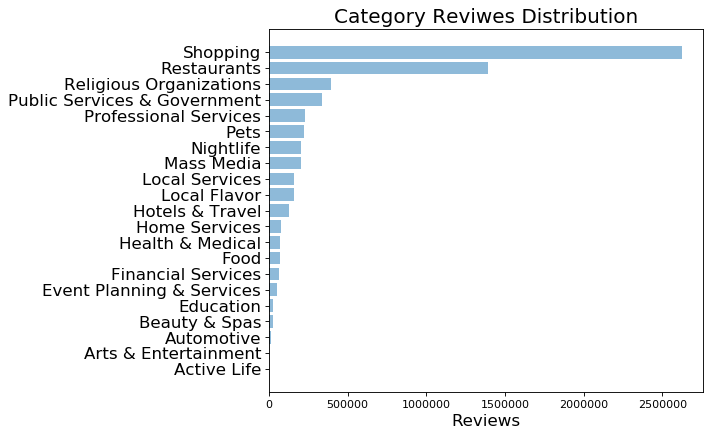

In [87]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

objects = topcat['top_category']
y_pos = np.arange(len(objects))
performance = sorted(topcat['biz_user_pair'])

fig=plt.figure(figsize=(7,6), dpi= 80, facecolor='w', edgecolor='k')

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, size = 15)
plt.xticks(size = 10)
plt.xlabel('Reviews', size = 15)
plt.title('Category Reviwes Distribution', size = 18)

plt.savefig('categorydist', format='eps')

plt.show()